In [1]:
from snn_delays.snn_refactored import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.train_utils_refact_minimal import train, get_device, propagate_batch_simple, to_plot
from snn_delays.utils.test_behavior import tb_addtask_refact
# from snn_delays.utils.visualization_utils import plot_taus
import numpy as np
device = get_device()

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda:0


In [2]:
time_window = 50
batch_size = 128 # 128: anil kag

ckpt_dir = 'copymemory_04_2025_tests'

dataset = 'copymemory'
#dataset = 'addtask' 

DL = DatasetLoader(dataset=dataset, caching='memory', num_workers=0, batch_size=batch_size, total_time=time_window)
train_loader, test_loader, dataset_dict = DL.get_dataloaders()
dataset_dict["time_ms"] = 2e3

for img, lbl in train_loader:
    print(img.shape)
    print(lbl.shape)
    break

torch.Size([128, 50, 1])
torch.Size([128, 5, 1])


Training copy memory task

In [3]:
num_h = 128

# extra_kwargs = {'multifeedforward':3}
# snn_f = SNN(dataset_dict, structure=(num_h, 2, 'mf'), win=time_window,
#              loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

# snn_f.set_layers()
# snn_f.num_train_samples = batch_size
# snn_f.to(device)

# snn_rnn = SNN(dataset_dict, structure=(num_h, 2, 'r'), win=time_window,
#                loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=False)

# snn_rnn.set_layers()
# snn_rnn.num_train_samples = batch_size
# snn_rnn.to(device)

extra_kwargs = {'delay_range':(40, 1),
                'pruned_delays': 3}

snn_rd = SNN(dataset_dict, structure=(num_h, 2, 'd'), win=time_window,
               loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_rd.set_layers()
snn_rd.num_train_samples = batch_size
snn_rd.to(device)

Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms


SNN(
  (criterion): MSELoss()
  (layers): ModuleList(
    (0): FeedforwardSNNLayer(
      (linear): Linear(in_features=1, out_features=128, bias=False)
    )
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=5120, out_features=128, bias=False)
    )
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=128, out_features=1, bias=False)
    )
  )
)

In [4]:
snn_rd

SNN(
  (criterion): MSELoss()
  (layers): ModuleList(
    (0): FeedforwardSNNLayer(
      (linear): Linear(in_features=1, out_features=128, bias=False)
    )
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=5120, out_features=128, bias=False)
    )
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=128, out_features=1, bias=False)
    )
  )
)

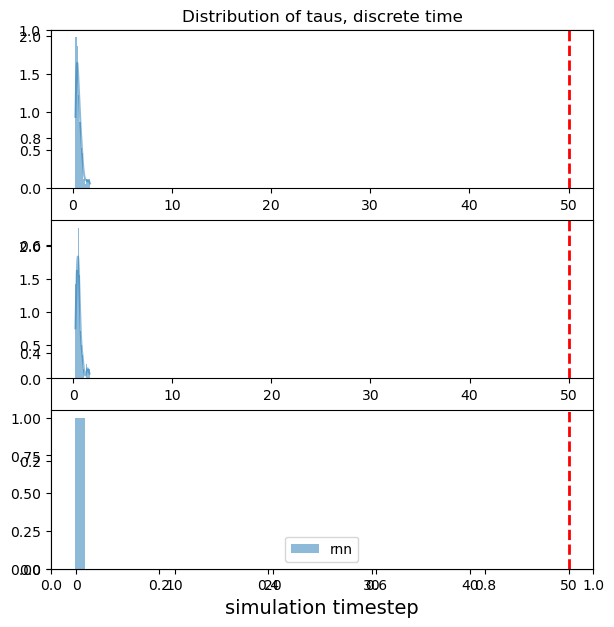

In [5]:
import matplotlib.pyplot as plt
from snn_delays.utils.visualization_utils import plot_param
import torch

def plot_taus(snn, label = 'taus', mode='discrete'):

    '''
    mode: real or discrete
    '''

    delta_t = snn.dataset_dict.get('time_ms', 0)/snn.win

    tau_m_params = [param for name, param in snn.named_parameters() if 'tau' in name]

    num_subplots = len(tau_m_params)

    plt.title(f'Distribution of taus, {mode} time')
    for i, pseudo_tau_m in enumerate(tau_m_params):

        real_tau = -delta_t/torch.log(torch.sigmoid(pseudo_tau_m))

        if mode=='real':
            plt.subplot(num_subplots, 1, i+1)
            plot_param(real_tau, mode='histogram', label=label, distribution='kde')
            if i==num_subplots-1:
                plt.xlabel('time (ms)')

        elif mode=='discrete':
            plt.subplot(num_subplots, 1, i+1)
            #plot_param(real_tau/snn.win, mode='histogram')    
            plot_param(real_tau/delta_t, mode='histogram', label=label, distribution='kde')
            plt.axvline(x=snn.win, color='red', linestyle='--', linewidth=2)
    #        plt.xlim(0, snn.win)
            if i==num_subplots-1:
                plt.xlabel('simulation timestep')

        else:
            raise ValueError(f"Unsupported: {mode}. Choose from 'real', 'discrete'.")

plt.figure(figsize=(7,7))
plot_taus(snn_rd, label='rnn')
plt.legend()

In [6]:
lr_tau = 0.1
#train(snn_f, train_loader, test_loader, 1e-3, 3000, ckpt_dir=ckpt_dir, test_behavior=tb_addtask_refact, scheduler=(100, 0.95), clear=True, lr_tau=lr_tau)
#train(snn_rnn, train_loader, test_loader, 1e-3, 3000, ckpt_dir=ckpt_dir, test_behavior=tb_addtask_refact, scheduler=(100, 0.95), clear=True, lr_tau=lr_tau)
train(snn_rd, train_loader, test_loader, 1e-3, 3000, gradient_clipping=False,
      ckpt_dir=ckpt_dir, test_behavior=tb_addtask_refact, scheduler=(100, 0.95), clear=True, lr_tau=lr_tau)

Mean Error: 0.04298891872167587% 
--------------------------


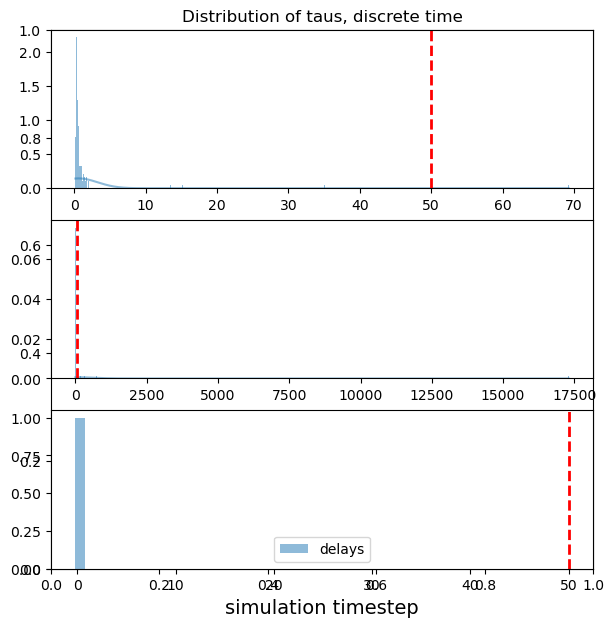

In [7]:
plt.figure(figsize=(7,7))
plot_taus(snn_rd, label='delays')
plt.legend()

Text(0.5, 1.0, 'train loss')

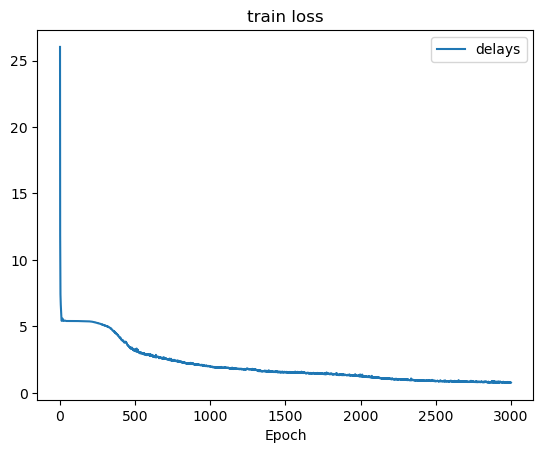

In [ ]:
import numpy as np
from snn_delays.utils.visualization_utils import plot_per_epoch
plot_per_epoch(snn_rd.train_loss, label = 'delays')
#plt.title(f'loss error = {loss_error}')

plt.title('train loss')

In [9]:
# snn_f.debug = True
# snn_rnn.debug = True
snn_rd.debug = True
# snn_f.init_state_logger()
# snn_rnn.init_state_logger()
snn_rd.init_state_logger()

from snn_delays.utils.train_utils_refact_minimal import propagate_batch_simple
# images, labels_mf = propagate_batch_simple(snn_f, test_loader)
# _, labels_rnn = propagate_batch_simple(snn_rnn, test_loader)
_, labels_rd = propagate_batch_simple(snn_rd, test_loader)

In [10]:
# ref_mf = labels_mf[:,:int(0.1*time_window),0].T.cpu().numpy()
# out_mf = snn_f.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()

# ref_rnn = labels_rnn[:,:int(0.1*time_window),0].T.cpu().numpy()
# out_rnn = snn_rnn.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()

ref_rd = labels_rd[:,:int(0.1*time_window),0].T.cpu().numpy()
out_rd = snn_rd.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()

-0.038305196166038516


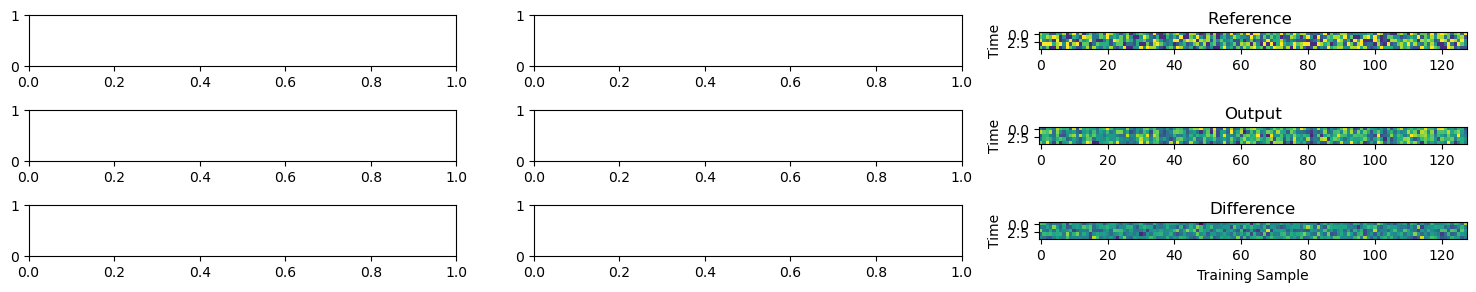

In [11]:
from snn_delays.utils.visualization_utils import plot_add_task, plot_add_task2, plot_add_task3, plot_add_task4
# Create a figure with 3 rows and N columns (for stacking results horizontally)
fig, axes = plt.subplots(3, 3, figsize=(15, 3))  # 3 rows, 2 columns

def plot_add_task(output, reference, axes=None, name=''):
    ref = reference
    out = output

    if out.ndim < 3:  # Ensure output has at least 3 dimensions
        raise ValueError("Expected output to have at least 3 dimensions")

    diff = ref - out[:, :, 0]

    print(np.mean(diff))

    if axes is None:
        fig, axes = plt.subplots(3, 1, figsize=(5, 10))  # Create a new figure if axes not provided

    axes[0].imshow(ref, vmin=0, vmax=8)
    axes[0].set_title('Reference '+name)
    axes[0].set_ylabel('Time')

    axes[1].imshow(out[:, :, 0], vmin=0, vmax=8)
    axes[1].set_title('Output')
    axes[1].set_ylabel('Time')

    axes[2].imshow(diff, vmin=-8, vmax=8)
    axes[2].set_title('Difference')
    axes[2].set_ylabel('Time')
    axes[2].set_xlabel('Training Sample')

    return axes  # Return the axes to be used in an external figure


# plot_add_task(out_mf, ref_mf, axes[:, 0])  
# plot_add_task(out_rnn, ref_rnn, axes[:, 1])  
plot_add_task(out_rd, ref_rd, axes[:, 2])  

plt.tight_layout()
plt.show()